# Comparing Reddit user engagement across fake, factual, corrective, and regular news

## Motivation

The recent focus on fake news in Western democracies within social sciences has also given rise to the related notion of astroturfing. As defined by Zhang et al. (2013):

> "Online astroturfing refers to coordinated campaigns where messages supporting a specific agenda are distributed via the Internet. These messages employ deception to create the appearance of being generated by an independent entity."

In this perspective, astroturfing can be viewed as a mechanism that enables the initial spread of a fake news item on social media. By initially associating a fake news story with artificial user activity to mimic grassroots activity, the story may gather increased attention from regular users and achieve greater user engagement over the full duration of its lifespan. 

As an example, a recent study on Twitter found that fake news are 70% more likely to be shared than factual news, and that fake news stories reach the first 1,500 users six times faster than factual news stories (Vosoughi et al., 2018).

While the spread of fake news has been studied extensively on Twitter, few studies have been conducted on Reddit. In this study, then, we will analyze whether the effect of a Reddit post's initial user engagement on total user engagement is dependent on the specific type of news story.

> Vosoughi, S., Roy, D., & Aral, S. (2018). The spread of true and false news online. Science, 359(6380), 1146-1151.

> Zhang, J., Carpenter, D., & Ko, M. (2013). Online astroturfing: A theoretical perspective.

---

## Data

<img src="../output/data_diagram_final_annotated.png" width="400" align="center"/>

To construct the dataset, we collect 695,147,095 Reddit posts from [Pushshift](https://pushshift.io). This constitutes every submission made between January 2016 and April 2020. We also rely on [the ClaimReview Project](https://www.claimreviewproject.com), a collective of verified journalists and fact-checkers, to obtain structured reviews of news items by scraping 151,025 ClaimReviews from [Google Fact Check Explorer](https://toolbox.google.com/factcheck/explorer) spanning from January 2015 to October 2020.

Merging these two datasets, we obtain two collections of post-review pairs: One representing the Reddit posts that link to articles that have also been reviewed by fact checkers; and another representing the posts that link directly to the corrective review articles themselves.

Since not all reviews include a quantitative truthfulness score, we include only those pairs that are numerically scored as either fake or factual. In total, we obtain 4,696 posts linking to news articles, and 16,938 linking to review articles. Among the news articles, 1,571 claims were deemed true while 3,125 were proven false. Similarly, 4,190 reviews verfied the corresponding claim as true while 12,748 disproved the claim as false.

Note that some news articles may contain multiple claims reviewed separately. In the following, we consider a news story as fake if at least one of the reviews pertaining to it identify a claim as false.

In [1]:
import sys
sys.path.insert(0, '../model')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time
from collections import defaultdict

import pyro
import torch
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.contrib.autoguide import AutoDiagonalNormal

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data
from post_model import post_model, post_guide
from type_model import type_model, type_guide
from story_model import story_model, story_guide
from subreddit_model import subreddit_model, subreddit_guide
from complete_model import complete_model, complete_guide
from model_utils import get_y_pred, get_type_only_y_pred, get_s_means, get_r_means, get_t_means, get_mean_y_pred
from inference import run_svi, plot_losses
from evaluation import (
    plot_predictions, plot_predictions_by_subreddit, plot_ppc_grid, plot_pp_hdi, plot_expectations,
    get_samples, evaluate
)
import torch.autograd.profiler as profiler

pyro.enable_validation(True)

First, we load in our joined raw data of the matching reddit post and claim review pairs.

In [2]:
comments, corrections, news = load_raw_data()

Next, we process and unpack data, gathering relevant features for use in our regression models.

In [3]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments, minutes=60)

original_p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

Now, we take a log transform of post-level comments in the first hour to reason about the magnitude of the number of comments rather than the number directly (1 additional comment on a post with 5 comments may have a different effect than 1 additional comment on a post with 500 comments).

In [4]:
p_data = transform_data(original_p_data)

Finally, we split our data into test and train sets so that we can do separate evaluation on data which the model has not seen before.

In [5]:
train_data, test_data, unsplit_data = split_and_prep_data(original_p_data, p_data, t_data, s_data, r_data, y, p_types, p_stories, p_subreddits, train_frac=0.7)
original_p_data_train, p_data_train, y_train, p_types_train, p_stories_train, p_subreddits_train = train_data
original_p_data_test, p_data_test, y_test, p_types_test, p_stories_test, p_subreddits_test = test_data
t_data, s_data, r_data = unsplit_data

We use the test data only for the final evaluation and comparison of our models. That is, once all models have been fine-tuned using the training data.

----

## Models

In modeling the total engagement of a Reddit post, we start with the simplest possible model first and gradually build on more levels. In the first section, we simply analyze the expected engagement by type to expose any explicit biases. 

In our first model, we implement the post level to predict the total engagement of a post only from the number of comments made in the first hour of its lifetime. We then add on the type level to account for the four different content types (fake/factual news and corrections on fake/factual news). 

With these two core levels in place, we then add the story-level to account for stories being reposted in different subreddits, and the subreddit level to incorporate a dependency structure on subreddits with similar popularity.

### Expectations

As an initial check, we first calculate the expected total engagement of each type. The plot shows the distribution of total engagement over the posts in each content type group.

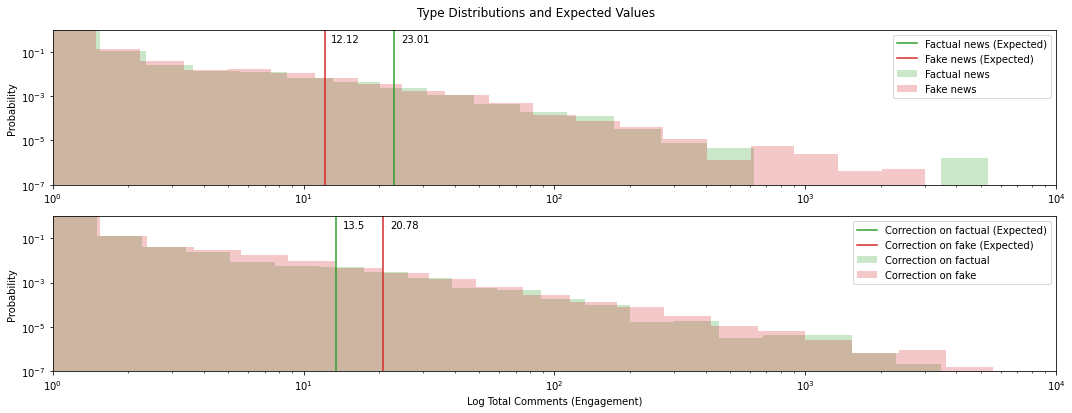

In [6]:
plot_expectations(y, p_types)

On expectation, factual news seem to generate the most comments, closely followed by corrective articles on fake news. Perhaps surprisingly, the least overall engagement seems to correspond to fake news articles, contradicting the previously mentioned results from Twitter. This may suggest that the information propagation dynamics on Reddit are radically different from those on Twitter. 

To analyze these differences further, we will now turn to actual model building.

### Post level

Our first model includes only the post-level itself. At the post level, we regress the number of initial comments for a given post against the total number of comments over its entire lifetime. The initial comments are defined as comments made within the first 60 minutes since the post was submitted on Reddit.

Graphically, we can represent this model as follows:

<img src="../output/model_post.png" width="400" align="center"/>

Having already imported the model, we now fit it to the training data using stochastic variational inference (SVI).

In [6]:
post_svi, post_losses = run_svi(post_model, post_guide, train_data, unsplit_data, num_iters=500, lr=1e-2)

As we can see, the variational distribution quickly converges to an estimate of the posterior.

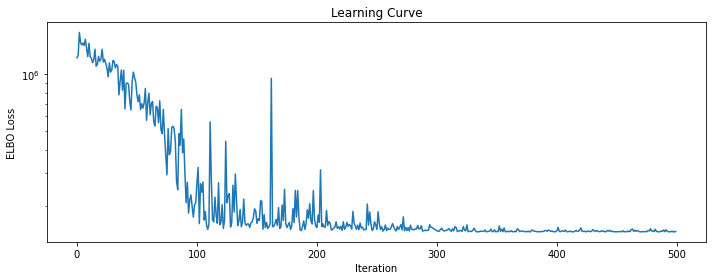

In [7]:
plot_losses(post_losses, log_scale = True, skip_first = 0)

Comparing the predicted values to the actual values, we notice that the total engagement of a post appears to be relatively easy to predict from just the number of initial comments.

Also note that the model does not include information about the types of news stories yet, why the predictions are identical across groups.

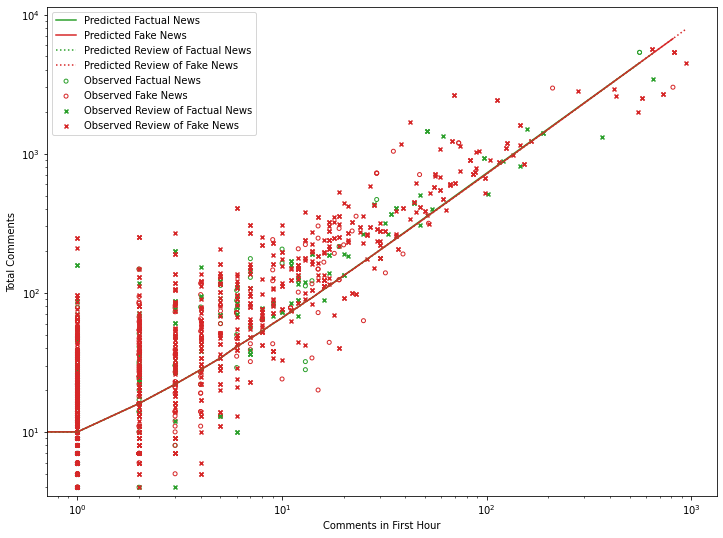

In [8]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, p_types_train, p_stories_train, p_subreddits_train)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=1, log_scale=True)

To analyze the model further, we now generate random samples from the posterior predictive distribution.

In [9]:
posterior_predictive_samples = get_samples(
    post_model, post_guide, 
    p_data_train, t_data, s_data, r_data, 
    None, 
    p_types_train, p_stories_train, p_subreddits_train,
    False,
    num_samples=1000,
)

Using these, we can plot the high density interval where 99% of the predicted observations fall. Note that due to the use of SVI, the variance of our predictions is clearly an underestimate of the actual variance of the observed samples.

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


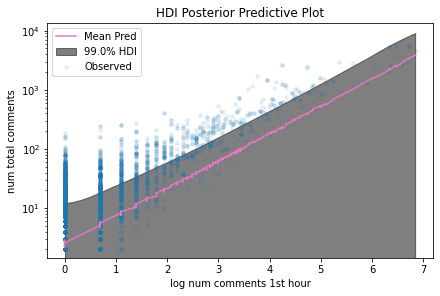

In [10]:
plot_pp_hdi(posterior_predictive_samples, p_data_train, y_train, hdi_prob=0.99)

We draw on posterior predictive checks to get a better sense of the behavior of our posterior predictive distribution. In particular, we note that the fraction of zeros in the predictive distribution seems to follow the observed distribution well. Similarly, the predicted max resembles the actual max decently well, although the predictions tend to be slightly larger.

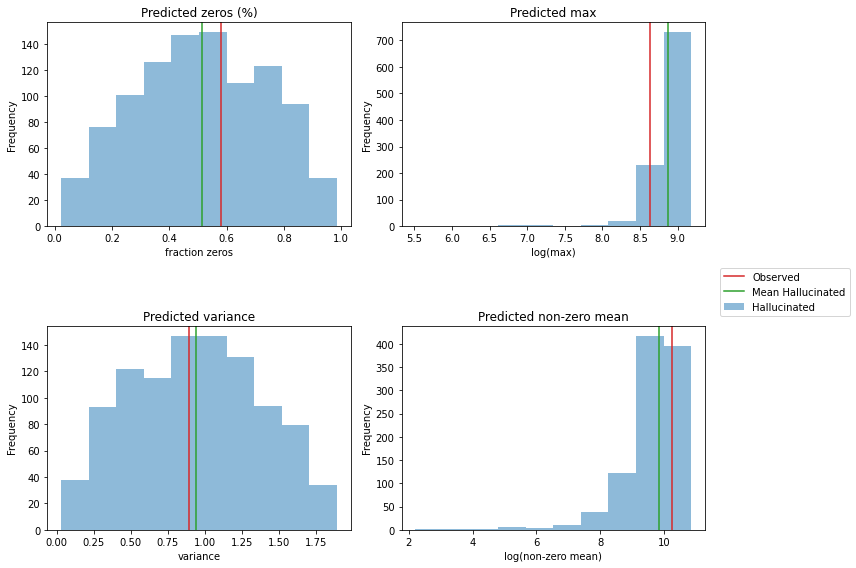

In [11]:
plot_ppc_grid(posterior_predictive_samples, y_train)

To evaluate the overall fit of our model to the training data, we calculate both $R^2$ and the mean absolute error (MAE) on both the original and the log transformed count data.

We note that although $R^2$ indicates that a relatively large fraction of the total variance is explained by the model, the effect is reversed when evaluated on the log transformed data. This suggests that the explained variance is largely driven by outliers, so the robustness of our model may be deceiving.

In [12]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, 
                    p_types_train, p_stories_train, p_subreddits_train)
results = evaluate(None, y_train, y_pred, partition='train', model='post')

pd.DataFrame(results['train'])

,post
MAE,12.512145
MAE_log,1.366763
R^2,0.730325
R^2_log,-0.136252


Before we proceed to implement the type level, we calculate and store the same metrics evaluated on the test data.

In [ ]:
y_pred = get_y_pred(p_data_test, t_data, s_data, r_data, 
                    p_types_test, p_stories_test, p_subreddits_test)
results = evaluate(results, y_test, y_pred, partition='test', model='post')

### Type level

In order to capture the difference in how different types of posts gain exposure, we next model each post as belonging to one of four "type" groups: 
1. Real News
2. Fake News
3. Review of Real News
4. Review of Fake News

Because each post belongs to exactly one of these type groups, we can depict this model graphically as shown below:

<img src="../output/model_type.png" width="400" align="center"/>

It is possible that due to astroturfing, we may see a disproportionately high number of total comments per first-hour comment, because the first hour may have artificially many reviews (those from the astroturfers). However, the more successful the astroturfing was, the more total comments we would expect to see overall, potentially counteracting this first effect. 

Additionally, reviews may go through a different process of gaining exposure than news articles do, so we have separate groups for reviews of both real and fake news.

Let's again start by fitting our model.

In [13]:
type_svi, type_losses = run_svi(type_model, type_guide, train_data, unsplit_data, num_iters=3000, lr=1e-2)

Visualizing the losses, we build confidence that our model has converged.

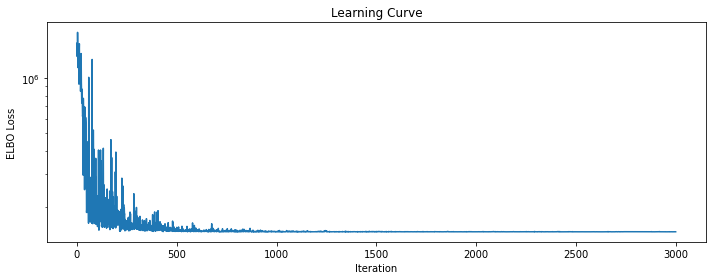

In [14]:
plot_losses(type_losses, log_scale = True, skip_first = 0)

Now we can more clearly see the differences between groups. At first glance, we may note that among posts with no comments in the first hour, reviews of fake news seem to generate the most discussion. This may be due to the delayed effect of users having to more thoroughly review and reflect on the correction articles before commenting. Conversely, factual news seem to quickly become irrelevant if noone engages in the first hour.

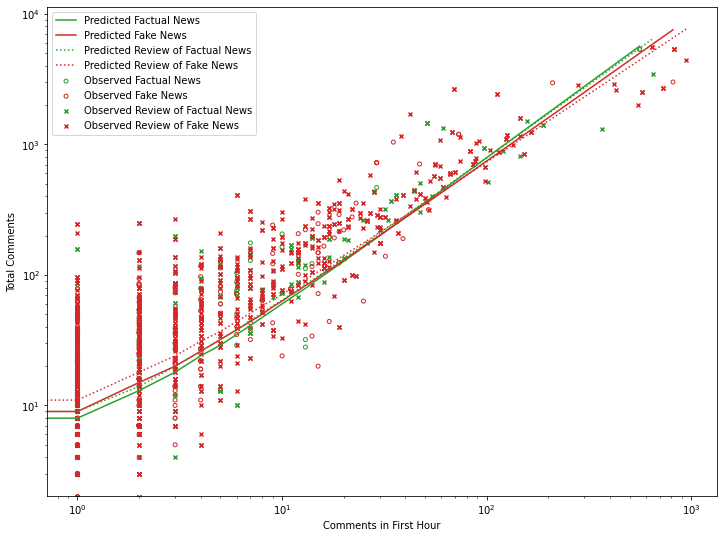

In [15]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, p_types_train, p_stories_train, p_subreddits_train)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=1, log_scale=True)

Let's again take a closer look at our model's posterior predictive distribution.

In [16]:
posterior_predictive_samples = get_samples(
    type_model, type_guide, 
    p_data_train, t_data, s_data, r_data, 
    None, 
    p_types_train, p_stories_train, p_subreddits_train,
    False,
    num_samples=1000,
)

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


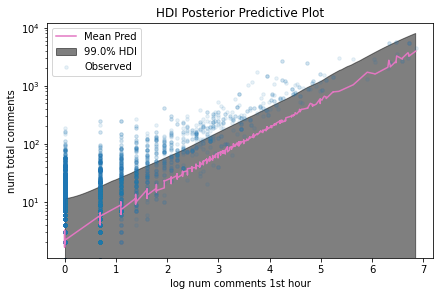

In [17]:
plot_pp_hdi(posterior_predictive_samples, p_data_train, y_train, hdi_prob=0.99)

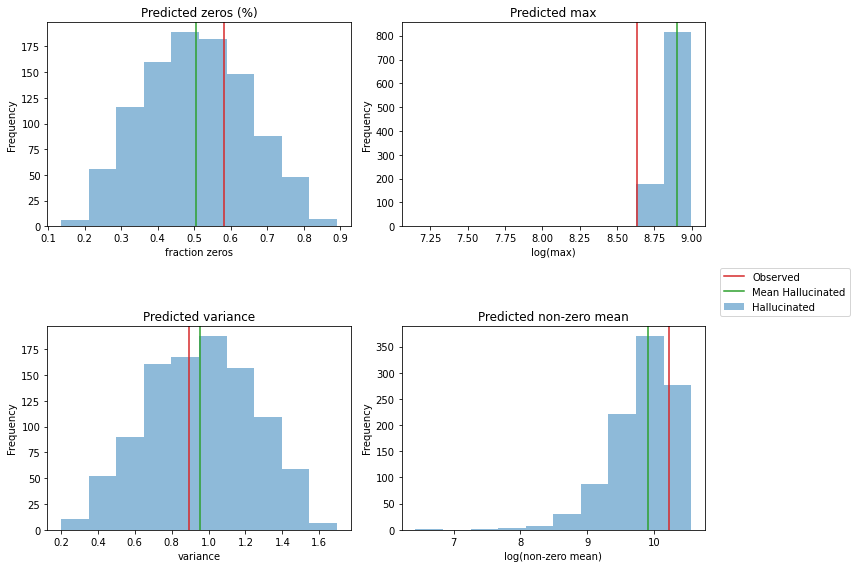

In [18]:
plot_ppc_grid(posterior_predictive_samples, y_train)

In [19]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, 
                    p_types_train, p_stories_train, p_subreddits_train)
results = evaluate(results, y_train, y_pred, partition='train', model='type')
pd.DataFrame(results['train'])

,post,type
R^2,0.730325,0.714914
R^2_log,-0.136252,-0.041163
MAE,12.512145,12.109178
MAE_log,1.366763,1.306936


In [20]:
y_pred = get_y_pred(p_data_test, t_data, s_data, r_data, 
                    p_types_test, p_stories_test, p_subreddits_test)
results = evaluate(results, y_test, y_pred, partition='test', model='type')

### Story level

In addition to varying at the post and type levels, each post refers to a specific story, whether it is a news post linking to the original source or a review article linking to a review of some potentially false claim in the original story. Namely, depending on the author of the story and which countries the story is relevant to, we will model some story-level variation in the model. Because each post refers to exactly one story, but multiple types may link to a single story, we create this regression model as portrayed by the following graphical representation:

<img src="../output/model_story.png" width="400" align="center"/>

As before, we first fit our model to the training data.

In [21]:
story_svi, story_losses = run_svi(story_model, story_guide, train_data, unsplit_data, num_iters=3000, lr=1e-2)

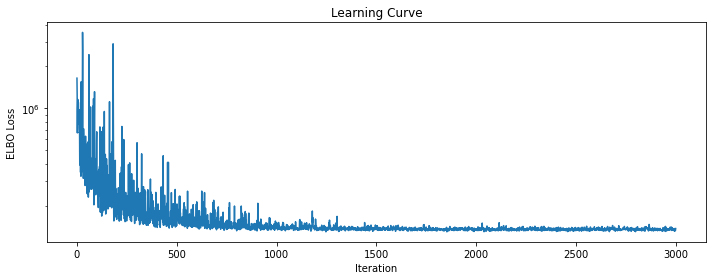

In [22]:
plot_losses(story_losses, log_scale = True, skip_first = 0)

Visually verifying the convergence of our model, we again plot the predictions against the actual observations.

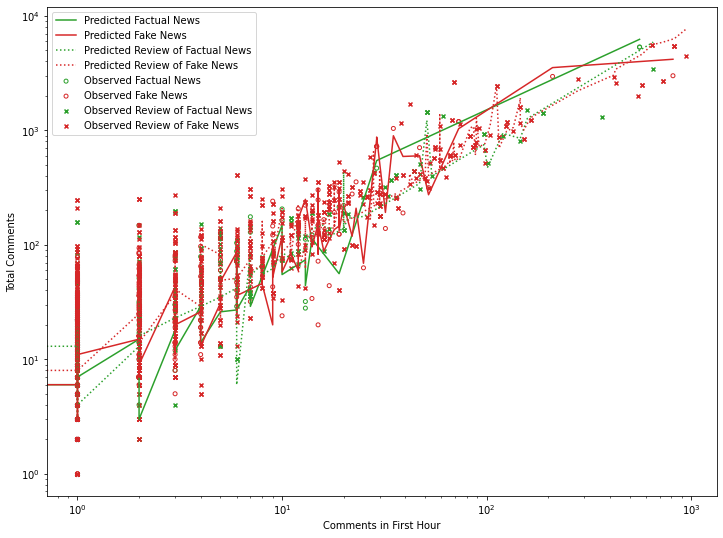

In [23]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, p_types_train, p_stories_train, p_subreddits_train)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=1, log_scale=True)

In [24]:
posterior_predictive_samples = get_samples(
    story_model, story_guide, 
    p_data_train, t_data, s_data, r_data, 
    None, 
    p_types_train, p_stories_train, p_subreddits_train,
    False,
    num_samples=1000,
)

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


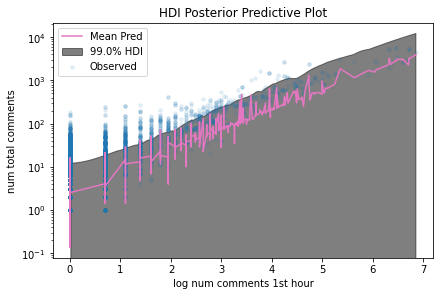

In [25]:
plot_pp_hdi(posterior_predictive_samples, p_data_train, y_train, hdi_prob=0.99)

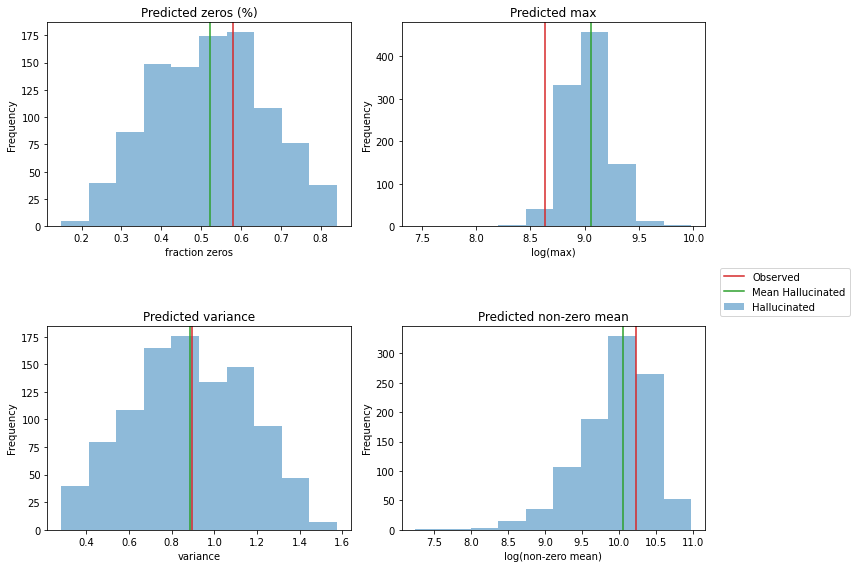

In [26]:
plot_ppc_grid(posterior_predictive_samples, y_train)

In [29]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, 
                    p_types_train, p_stories_train, p_subreddits_train)
results = evaluate(results, y_train, y_pred, partition='train', model='story')
pd.DataFrame(results['train'])

,post,type,story
R^2,0.730325,0.714914,0.805740
R^2_log,-0.136252,-0.041163,0.053550
MAE,12.512145,12.109178,10.642463
MAE_log,1.366763,1.306936,1.192231


In [30]:
y_pred = get_y_pred(p_data_test, t_data, s_data, r_data, 
                    p_types_test, p_stories_test, p_subreddits_test)
results = evaluate(results, y_test, y_pred, partition='test', model='story')

### Subreddit level

As an alternative to the story level, we consider the effect of subscribers at the subreddit level. Specifically, we expect that posts submitted to subreddits with similar subscriber counts may exhibit similar effects on engagement. Here, we use the number of subscribers the subreddit had a the time of submission to partition the posts into evenly sized groups at the subreddit-level.

Graphically, we may represent this model as follows:

<img src="../output/model_subreddit.png" width="400" align="center"/>

Following the usual procedure, we first fit our model to the training data.

In [31]:
subreddit_svi, subreddit_losses = run_svi(subreddit_model, subreddit_guide, train_data, unsplit_data, num_iters=3000, lr=1e-2)

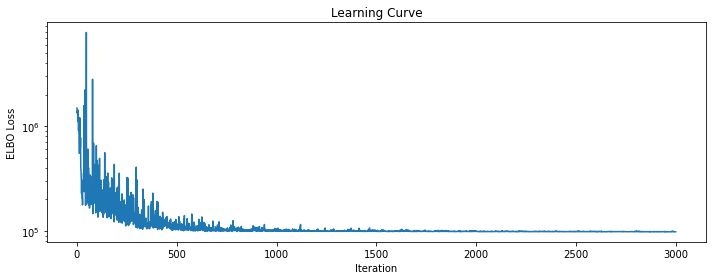

In [32]:
plot_losses(subreddit_losses, log_scale = True, skip_first = 0)

Checking the convergence of our model, we proceed to plot the predictions against the actual observations.

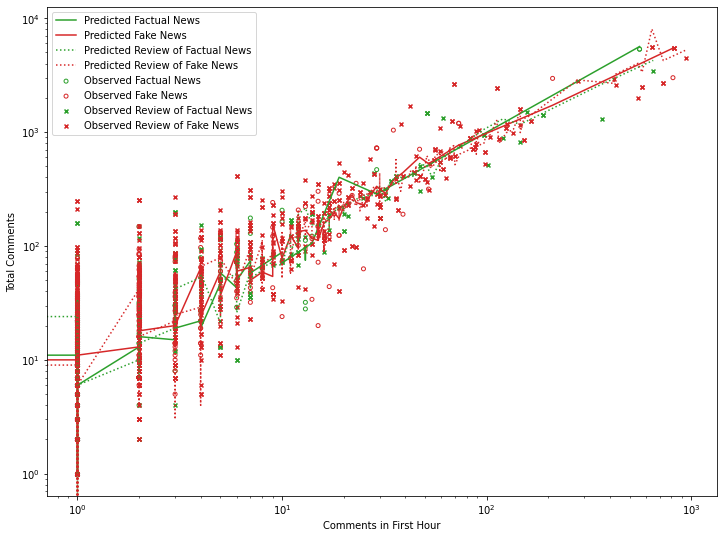

In [33]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, p_types_train, p_stories_train, p_subreddits_train)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=1, log_scale=True)

In [34]:
posterior_predictive_samples = get_samples(
    subreddit_model, subreddit_guide, 
    p_data_train, t_data, s_data, r_data, 
    None, 
    p_types_train, p_stories_train, p_subreddits_train,
    False,
    num_samples=1000,
)

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


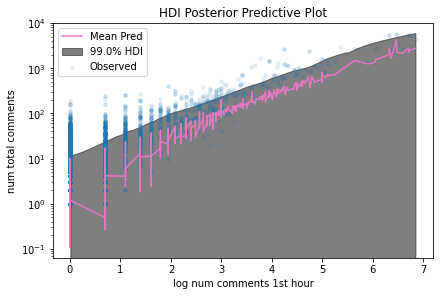

In [35]:
plot_pp_hdi(posterior_predictive_samples, p_data_train, y_train, hdi_prob=0.99)

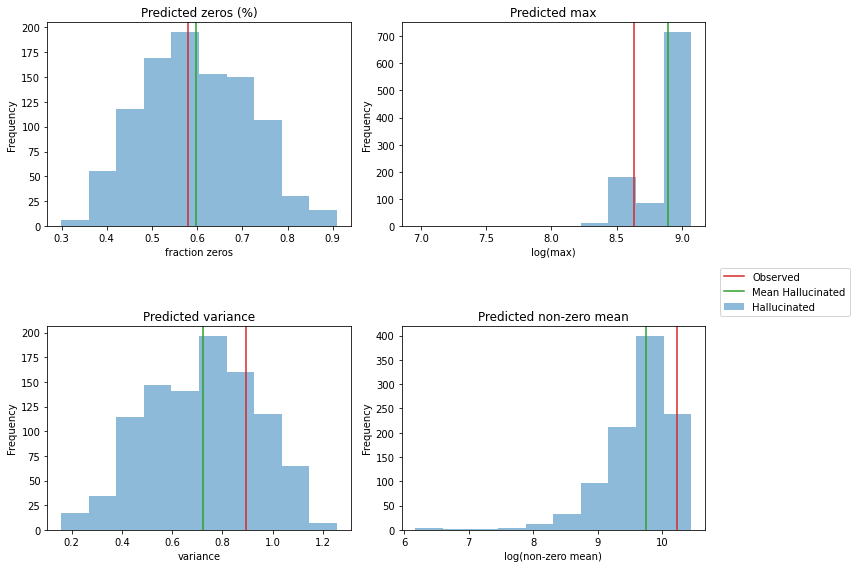

In [36]:
plot_ppc_grid(posterior_predictive_samples, y_train)

Another way to visualize our model is by inspecting each of the 25 groups at the subreddit level. Here we can more clearly see how the groups may now exhibit different slopes and offsets.

Note that some plots appear empty, but that the data points are really just 'hidden' at zero.

../model/evaluation.py:138: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


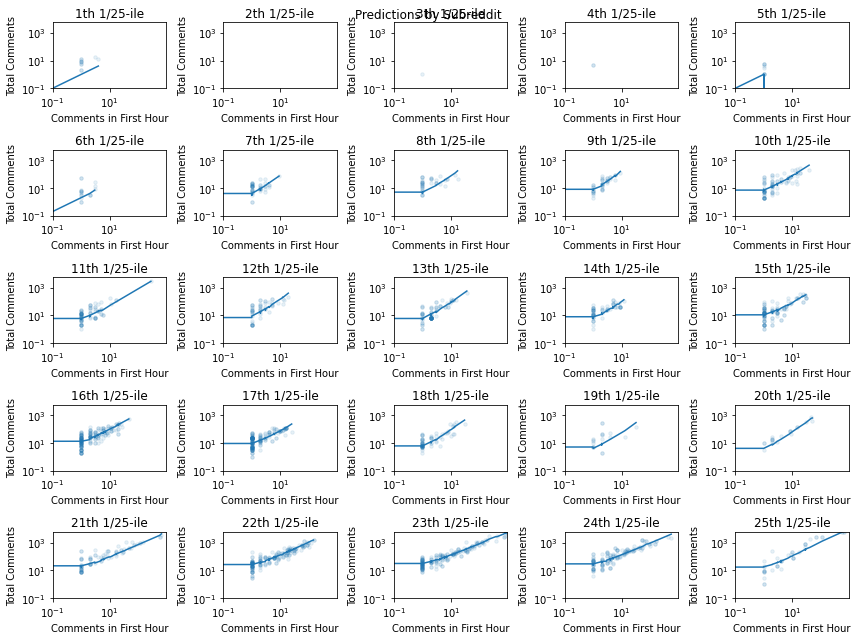

In [37]:
plot_predictions_by_subreddit(original_p_data_train, y_train, p_subreddits_train, original_p_data_train, y_pred, p_subreddits_train, indep=1, log_scale=True, alpha=0.1)

In [38]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, 
                    p_types_train, p_stories_train, p_subreddits_train)
results = evaluate(results, y_train, y_pred, partition='train', model='subreddit')
pd.DataFrame(results['train'])

,post,type,story,subreddit
R^2,0.730325,0.714914,0.805740,0.859516
R^2_log,-0.136252,-0.041163,0.053550,0.468015
MAE,12.512145,12.109178,10.642463,9.025210
MAE_log,1.366763,1.306936,1.192231,0.760473


In [39]:
y_pred = get_y_pred(p_data_test, t_data, s_data, r_data, 
                    p_types_test, p_stories_test, p_subreddits_test)
results = evaluate(results, y_test, y_pred, partition='test', model='subreddit')

### Complete model

Finally, we integrate all of the previous levels into our complete model. Here, we account for both the post, type, story, and subreddit levels to explain the engagement of a post.

Similar to the previous models, the complete model can be represented graphically as follows:

<img src="../output/model_complete.png" width="400" align="center"/>

In [ ]:
complete_svi, complete_losses = run_svi(complete_model, complete_guide, train_data, unsplit_data, num_iters=3000, lr=1e-2)

In [ ]:
plot_losses(complete_losses, log_scale = True, skip_first = 0)

In [ ]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, p_types_train, p_stories_train, p_subreddits_train)
plot_predictions(original_p_data_train, y_train, p_types_train, original_p_data_train, y_pred, p_types_train, indep=1, log_scale=True)

In [ ]:
posterior_predictive_samples = get_samples(
    complete_model, complete_guide, 
    p_data_train, t_data, s_data, r_data, 
    None, 
    p_types_train, p_stories_train, p_subreddits_train,
    False,
    num_samples=1000,
)

In [ ]:
plot_pp_hdi(posterior_predictive_samples, p_data_train, y_train, hdi_prob=0.99)

In [ ]:
plot_ppc_grid(posterior_predictive_samples, y_train)

In [ ]:
y_pred = get_y_pred(p_data_train, t_data, s_data, r_data, 
                    p_types_train, p_stories_train, p_subreddits_train)
results = evaluate(results, y_train, y_pred, partition='train', model='complete')
pd.DataFrame(results['train'])

In [ ]:
y_pred = get_y_pred(p_data_test, t_data, s_data, r_data, 
                    p_types_test, p_stories_test, p_subreddits_test)
results = evaluate(results, y_test, y_pred, partition='test', model='complete')

---

# Conclusion

In [ ]:
pd.DataFrame(results['train'])

In [ ]:
pd.DataFrame(results['test'])

---